In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv("owid-covid-data (1).csv")

In [ ]:
!pip install shap

In [ ]:
import shap

## Подготовка данных

In [ ]:
data = data[['location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index']]

In [ ]:
data['date']= pd.to_datetime(data['date'])

In [ ]:
# NaN заменены на нулевое значение, так как они соответствуют времени, когда вакцины не было
data[['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']] = data[['total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred']].fillna(0)

In [ ]:
# выбор Франции как основной страны
temp = data[data.location == 'France']

In [ ]:
# создание дамми, означающего отсутствие вакцинации
temp['before_vac'] = [1 if s == 0 else 0 for s in temp.total_vaccinations]

In [ ]:
temp=temp.set_index('date')

In [ ]:
temp = temp.interpolate('time')

In [ ]:
# избавление от неверных нулевых значений
temp.new_deaths[temp.new_deaths==0] = np.nan

In [ ]:
# избавление от значений, которые невозможно линейно интерполировать
temp=temp.dropna()

In [ ]:
# окончательный отбор переменных
temp = temp[['total_cases', 'new_cases', 'new_cases_smoothed', 'new_deaths', 
       'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 
       'icu_patients', 'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
       'new_vaccinations_smoothed_per_million',
       'new_people_vaccinated_smoothed',
       'new_people_vaccinated_smoothed_per_hundred', 'stringency_index', 'before_vac']]

## Построение моделей

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
temp.to_csv('4cov.csv')

In [ ]:
y = temp['new_deaths']
X = temp.drop('new_deaths', axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False)

In [ ]:
#Train model
model = xgb.XGBRegressor(objective="reg:squarederror") 
model.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

In [ ]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

-0.03982684304705031

In [ ]:
mean_absolute_percentage_error(y_test[:30], y_pred[:30])

0.6496455765910901

In [ ]:
import lightgbm

In [ ]:
#Train model
model = lightgbm.LGBMRegressor() 
model.fit(X_train, y_train)

LGBMRegressor()

In [ ]:
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.09463584873445308

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

1.9570378228233527

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

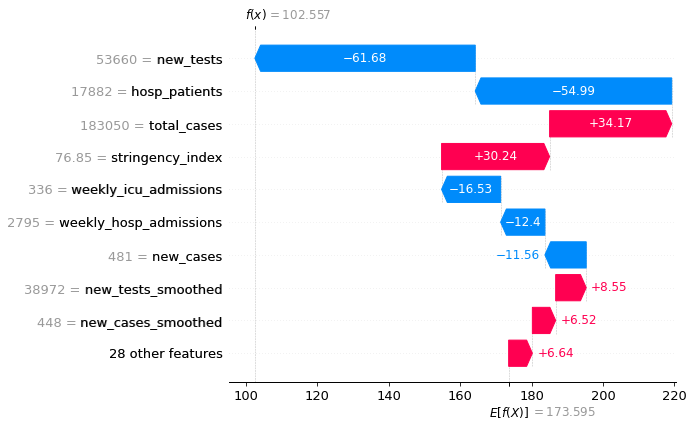

In [ ]:
# Waterfall plot for first observation
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()
# Forceplot for first observation
shap.plots.force(shap_values[0])

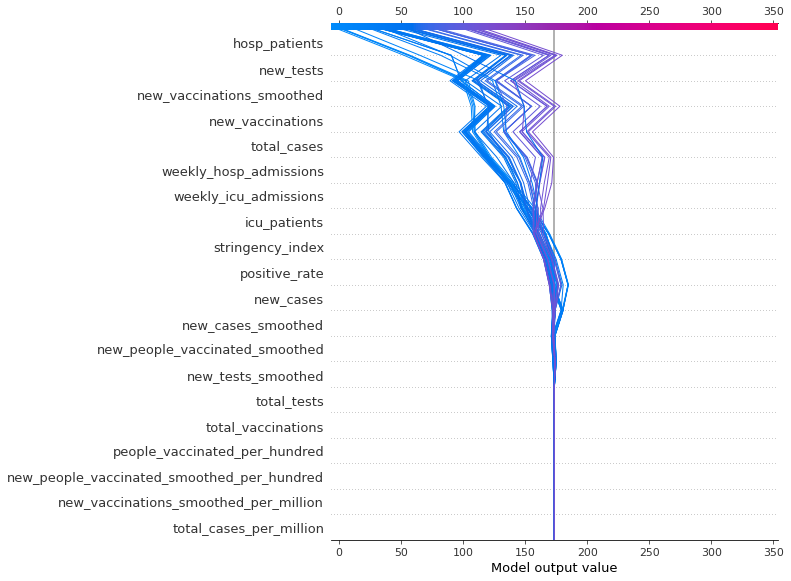

In [ ]:
# Get expected value and shap values array
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X)

#Descion plot for first 10 observations
shap.decision_plot(expected_value, shap_array[400:450],feature_names=list(X.columns))

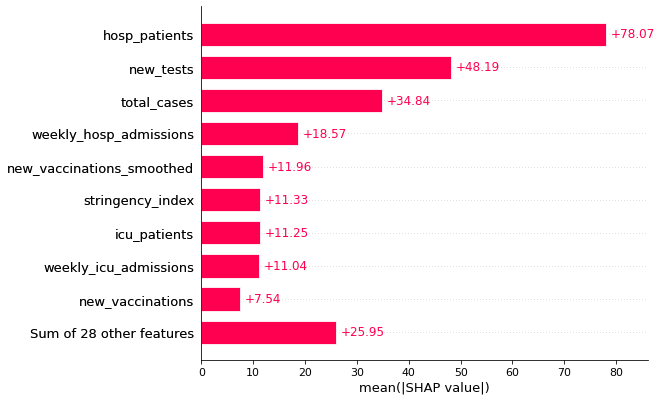

In [ ]:
#Mean SHAP
shap.plots.bar(shap_values)

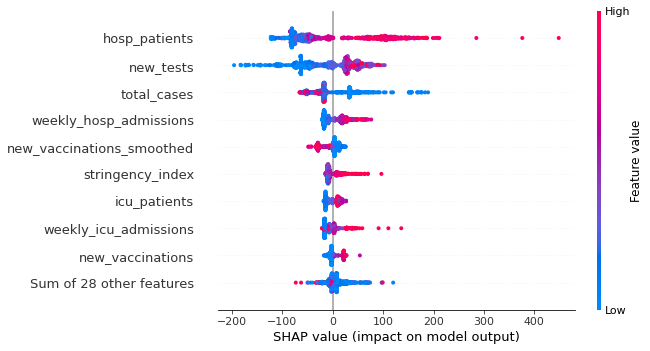

In [ ]:
# Beeswarm plot
shap.plots.beeswarm(shap_values)

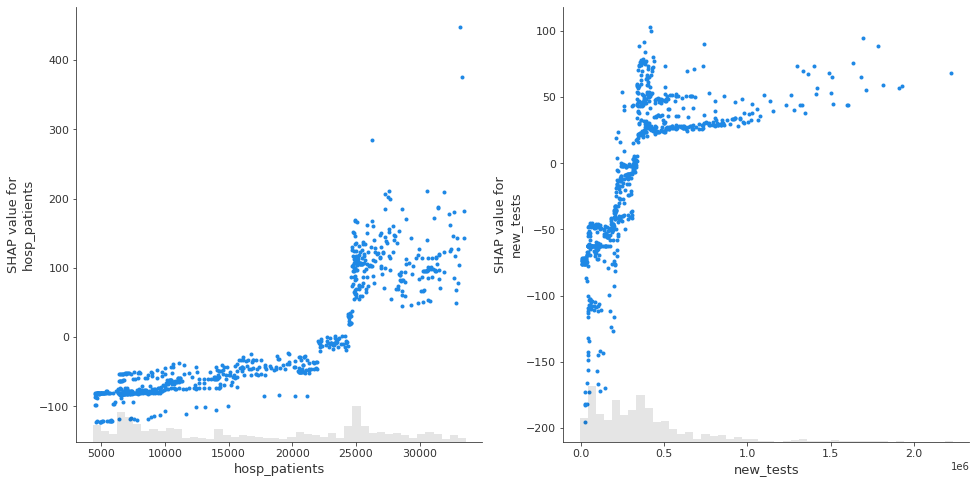

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

#SHAP scatter plots
shap.plots.scatter(shap_values[:,"hosp_patients"],ax=ax[0],show=False)
shap.plots.scatter(shap_values[:,"new_tests"],ax=ax[1])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
temp

,total_cases,new_cases,new_cases_smoothed,new_deaths,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,icu_patients,icu_patients_per_million,hosp_patients,...,new_vaccinations_smoothed,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,new_vaccinations_smoothed_per_million,new_people_vaccinated_smoothed,new_people_vaccinated_smoothed_per_hundred,stringency_index,before_vac
date,,,,,,,,,,,,,,,,,,,,,
2020-05-20,183050.0,481.0,448.0000,111.0,2714.989,7.134,6.6450,1754.0,26.015,17882.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,76.85,1
2020-05-21,183317.0,267.0,394.4290,82.0,2718.949,3.960,5.8500,1708.0,25.333,17527.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,76.85,1
2020-05-22,184073.0,756.0,429.1430,148.0,2730.162,11.213,6.3650,1664.0,24.680,17327.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,76.85,1
2020-05-23,184619.0,546.0,447.8570,86.0,2738.261,8.098,6.6430,1628.0,24.146,17122.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,76.85,1
2020-05-24,184180.0,435.5,429.3570,87.5,2731.749,6.459,6.3685,1618.0,23.998,17129.0,...,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000,76.85,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-11,29807699.0,47.0,19250.4285,39.0,442106.419,0.697,285.5215,875.0,12.978,14061.0,...,33375.0,215.24,80.80,78.48,57.57,495.0,1012.0,0.002,18.79,0
2022-06-14,29984235.0,176536.0,38654.7140,149.0,444724.793,2618.374,573.3250,854.0,12.666,14072.0,...,39091.0,215.39,80.80,78.48,57.71,580.0,1126.0,0.002,18.79,0
2022-06-15,30036189.0,51954.0,38390.7140,49.0,445495.372,770.579,569.4090,847.0,12.563,13910.0,...,39368.0,215.45,80.80,78.49,57.77,584.0,1119.0,0.002,18.79,0


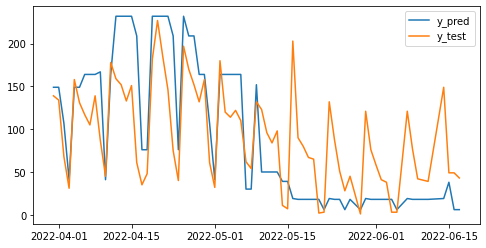

In [554]:
from matplotlib.pyplot import figure
figure(figsize=(8, 4))

plt.plot(y_test.index, list(y_pred), label='y_pred')
plt.plot(y_test.index, list(y_test), label='y_test')

plt.legend()
plt.show()

In [ ]:
y_pred

array([147.63983 , 147.63983 , 147.63983 , 140.6044  , 140.6044  ,
       125.18735 ,  43.070198, 147.63983 , 256.53168 , 246.21756 ,
       248.82901 , 263.80627 , 142.22775 ,  77.96308 ,  97.667496,
       260.88547 , 256.6237  , 222.44095 , 200.39545 , 140.69438 ,
        96.92894 , 272.72272 , 135.65306 , 109.90776 ,  63.378815,
        63.378815,  68.43917 ,  57.475075, 132.00838 ,  68.303795,
        69.172264,  64.67694 ,  64.67694 ,  56.162563,  56.162563,
       110.202286,  80.541664,  65.53554 ,  58.10789 ,  58.10789 ,
        43.591705,  68.344696,  83.97589 ,  45.241795,  45.746902,
        34.782818,  34.782818,  47.436157,  45.61888 ,  56.5121  ,
        32.27713 ,  44.93048 ,  44.93048 ,  30.783344,  73.74309 ,
        39.043427,  35.53517 ,  26.72403 ,  20.320917,  20.320917,
        24.291853,  24.291853,  36.9452  ,  33.611   ,  71.8043  ,
        37.367195,  30.694963,  25.016584,  18.613476, -66.10704 ,
       -33.49243 ,  56.171425,  53.93692 ,  45.372902,  41.459

In [ ]:
# 0.2560590724394488

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [ ]:
y_pred = reg.predict(X_test)
r2_score(y_test, y_pred)

-0.07376265727700737

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

2.696801869072439

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
model = auto_arima(y=y_train, X=X_train.drop(['tests_per_case', 'total_cases_per_million', 'new_cases_per_million', 
                                              'new_cases_smoothed_per_million', 'total_cases', 'total_boosters_per_hundred', 
                                              'new_vaccinations_smoothed_per_million', 'total_vaccinations_per_hundred',
                                              'people_vaccinated_per_hundred', 'new_tests_smoothed_per_thousand',
                                              'total_tests_per_thousand', 'new_people_vaccinated_smoothed_per_hundred',
                                              'new_people_vaccinated_smoothed', 'stringency_index'], axis=1), test='adf',
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8395.303, Time=2.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=8489.300, Time=1.51 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=8471.436, Time=1.60 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=8451.321, Time=1.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12269.441, Time=1.43 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=8390.134, Time=1.98 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=8391.135, Time=1.91 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=8435.971, Time=1.75 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=8425.795, Time=2.07 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=8436.709, Time=1.96 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8393.198, Time=1.84 sec


divide by zero encountered in reciprocal
divide by zero encountered in reciprocal


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=8550.990, Time=2.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8388.205, Time=1.90 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8389.209, Time=1.76 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8434.013, Time=1.65 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8393.349, Time=1.93 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8423.842, Time=1.96 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8449.357, Time=1.67 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=8434.766, Time=1.89 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8391.248, Time=1.76 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=8548.973, Time=2.03 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 38.625 seconds


divide by zero encountered in reciprocal
divide by zero encountered in reciprocal


In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  684
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -4168.102
Date:                Wed, 24 Aug 2022   AIC                           8388.205
Time:                        12:16:26   BIC                           8505.932
Sample:                    05-20-2020   HQIC                          8433.762
                         - 04-03-2022                                         
Covariance Type:                  opg                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
new_cases                               0.0006      0.000      4.714      0.000       0.000       0.001
new_cases_smoothed                     -0.0008      0.000     -3.838      0.000      -0.001      -0.000
icu_patients                           -3.4380      0.018   -192.736      0.000      -3.473      -3.403
icu_patients_per_million              236.2441      0.000   8.93e+05      0.000     236.244     236.245
hosp_patients                        -174.6374      0.003  -6.38e+04      0.000    -174.643    -174.632
hosp_patients_per_million            1.177e+04   4.06e-05    2.9e+08      0.000    1.18e+04    1.18e+04
weekly_icu_admissions                -373.5086      0.032  -1.18e+04      0.000    -373.571    -373.447
weekly_icu_admissions_per_million    2.517e+04      0.000   5.37e+07      0.000    2.52e+04    2.52e+04
weekly_hosp_admissions                -14.6302      0.005  -3078.260      0.000     -14.640     -14.621
weekly_hosp_admissions_per_million    989.8156   7.05e-05    1.4e+07      0.000     989.816     989.816
total_tests                          2.984e-06   7.69e-07      3.879      0.000    1.48e-06    4.49e-06
new_tests                              -0.2582   2.83e-05  -9131.553      0.000      -0.258      -0.258
new_tests_per_thousand               1.743e+04   4.62e-08   3.77e+11      0.000    1.74e+04    1.74e+04
new_tests_smoothed                     -0.0005   4.68e-05     -9.876      0.000      -0.001      -0.000
positive_rate                       -1275.0111   6.45e-06  -1.98e+08      0.000   -1275.011   -1275.011
total_vaccinations                     -0.0008      0.000     -4.048      0.000      -0.001      -0.000
people_vaccinated                       0.0008      0.000      4.001      0.000       0.000       0.001
people_fully_vaccinated                 0.0025      0.000     12.391      0.000       0.002       0.003
total_boosters                          0.0008      0.000      4.030      0.000       0.000       0.001
new_vaccinations                       -0.0002    5.8e-05     -2.668      0.008      -0.000    -4.1e-05
new_vaccinations_smoothed               0.0002   7.22e-05      2.866      0.004    6.54e-05       0.000
people_fully_vaccinated_per_hundred -1128.0009   3.63e-07  -3.11e+09      0.000   -1128.001   -1128.001
ar.L1                                  -0.3234      0.074     -4.370      0.000      -0.468      -0.178
ma.L1                                   0.0967      0.066      1.473      0.141      -0.032       0.225
ma.L2                                  -0.3602      0.033    -10.872      0.000      -0.425      -0.295
sigma2                               1.184e+04   3.15e-06   3.76e+09      0.000    1.18e+04    1.18e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              2203.21
Prob(Q):                              0.53   Prob(JB):   

In [ ]:
X_test.shape

(76, 36)

In [ ]:
X_train.shape

(684, 36)

In [ ]:
y_pred = model.predict(n_periods=76, X=X_test.drop(['tests_per_case', 'total_cases_per_million', 'new_cases_per_million', 
                                              'new_cases_smoothed_per_million', 'total_cases', 'total_boosters_per_hundred', 
                                              'new_vaccinations_smoothed_per_million', 'total_vaccinations_per_hundred',
                                              'people_vaccinated_per_hundred', 'new_tests_smoothed_per_thousand',
                                              'total_tests_per_thousand', 'new_people_vaccinated_smoothed_per_hundred',
                                              'new_people_vaccinated_smoothed', 'stringency_index'], axis=1))
r2_score(y_test, y_pred)

-0.4118150517640413

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=7)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [ ]:
y_pred = neigh.predict(X_test)
r2_score(y_test, y_pred)

-0.14278355796986286

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

4.776253745840793

In [ ]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred = regressor.predict(X_test)
r2_score(y_test, y_pred)

-0.07521497041479841

In [ ]:
from sklearn import linear_model
clf = linear_model.BayesianRidge()
clf.fit(X_train, y_train)

BayesianRidge()

In [ ]:
y_pred = clf.predict(X_test)
r2_score(y_test, y_pred)

0.12348743940427986

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

1.3338709950397096

Оптимизация гиперпараметров про помощи библиотеки Optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 29.7 MB/s 
     |████████████████████████████████| 81 kB 9.7 MB/s 
     |████████████████████████████████| 209 kB 76.8 MB/s 
     |████████████████████████████████| 78 kB 9.4 MB/s 
     |████████████████████████████████| 112 kB 77.7 MB/s 
     |████████████████████████████████| 49 kB 7.9 MB/s 
     |████████████████████████████████| 147 kB 73.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=18e81525f0d8292881b6c082e0263844c8649465b61fbb4d7b4030fc7c5e7516
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
from sklearn.model_selection import cross_val_score
def objective(trial, y, X):
    alpha_1 = trial.suggest_int("alpha_1", 0, 0.1)
    alpha_2 = trial.suggest_float("alpha_2", 0, 0.1)
    lambda_1 = trial.suggest_int("lambda_1", 0, 0.1)
    lambda_2 = trial.suggest_float("lambda_2", 0, 0.1)
   
    clf = linear_model.BayesianRidge(
        alpha_1 = alpha_1,
        alpha_2 = alpha_2,
        lambda_1 = lambda_1,
        lambda_2 = lambda_2)
    score = cross_val_score(clf, X, y,  cv=3).mean()
    return score

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(lambda trial: objective(
        trial,y=y_train, X=X_train), n_trials = 1000)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

In [ ]:
from sklearn import linear_model

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
# Проверка хорошего качества модели на трейне
clf = linear_model.BayesianRidge(alpha_1= 0,
  alpha_2= 0.01615623199455616,
  lambda_1= 0,
  lambda_2= 1.490377792677951e-08)
clf.fit(X_train, y_train)

BayesianRidge(alpha_1=0, alpha_2=0.01615623199455616, lambda_1=0,
              lambda_2=1.490377792677951e-08)

In [ ]:
y_pred = clf.predict(X_test)
r2_score(y_test, y_pred)

0.26855063520777833

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test[:20], y_pred[:20])

0.526930314077671

In [ ]:
# обучение модели на всех данных
clf = linear_model.BayesianRidge(alpha_1= 0,
  alpha_2= 0.01615623199455616,
  lambda_1= 0,
  lambda_2= 1.490377792677951e-08)
clf.fit(X, y)

BayesianRidge(alpha_1=0, alpha_2=0.01615623199455616, lambda_1=0,
              lambda_2=1.490377792677951e-08)

In [ ]:
explainer = shap.KernelExplainer(clf.predict, X)

X does not have valid feature names, but BayesianRidge was fitted with feature names


In [ ]:
# построение графиков только на выборке
shap_values = explainer.shap_values(shap.sample(X, 50))

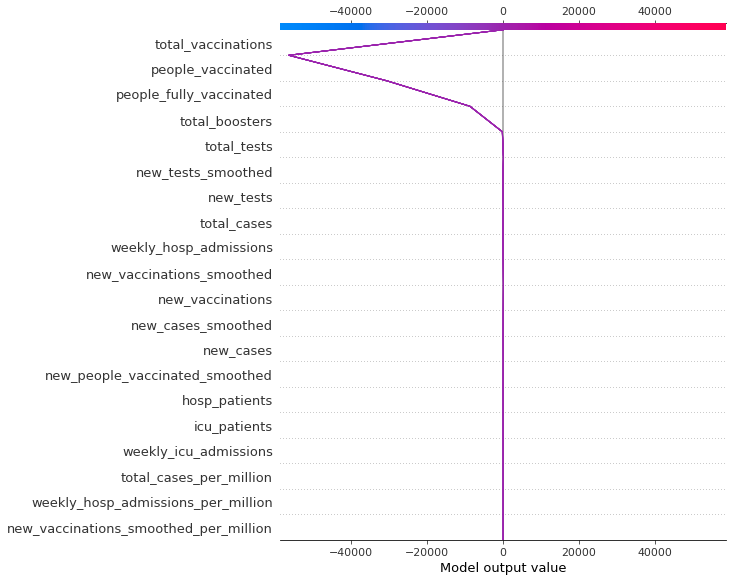

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values, X.iloc[:10])